Related arXiv paper (I think):
- [Assemblies of neurons learn to classify well-separated distributions](https://arxiv.org/abs/2110.03171)

In [1]:
! pip install -q  numpy  scipy  matplotlib 
! pip install -q  scikit-learn pandas  # for loading mnist dataset
! pip install -q  tqdm

In [2]:
from tqdm import tqdm

In [3]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
rng = np.random.default_rng()

In [4]:
# #Note -- place your own MNIST files in the appropriate directory
# train_data = np.loadtxt("./data/mnist/mnist_train.csv", delimiter=',')
# test_data = np.loadtxt("./data/mnist/mnist_test.csv", delimiter=',')

In [5]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

# mnist.data contains the images, and mnist.target contains the labels.
X, y = mnist['data'], mnist['target']

# Convert labels to integers
y = y.astype(int)

# Split the data into training and testing datasets
# Here, we use 60,000 records for training and the rest for testing, matching the MNIST original split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=42)

# Optionally, you might want to normalize the features to a range of 0 to 1
X_train = X_train / 255.0
X_test = X_test / 255.0

# If you need to combine the labels with the images for some reason similar to your original CSV structure
# You can do so by using numpy's column_stack function
train_data = np.column_stack((y_train, X_train))
test_data = np.column_stack((y_test, X_test))

print("MNIST dataset loaded and split into train and test data.")


MNIST dataset loaded and split into train and test data.


In [6]:
train_data.shape

(60000, 785)

In [7]:
train_imgs = train_data[:, 1:]
test_imgs = test_data[:, 1:]
train_labels = train_data[:, 0]
test_labels = test_data[:, 0]

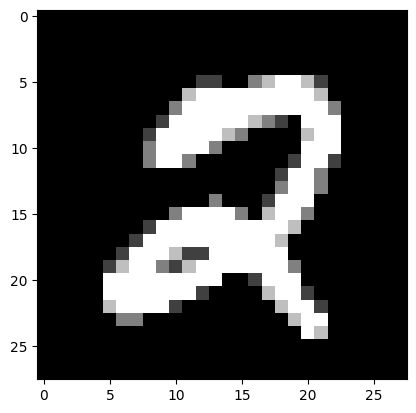

In [8]:
from matplotlib import pyplot as plt
im = train_imgs[0].reshape(28, 28)
im.shape

plt.imshow(im, cmap='gray')

In [69]:
def k_cap(input, cap_size):
    output = np.zeros_like(input)
    if len(input.shape) == 1:
        idx = np.argsort(input)[-cap_size:]
        output[idx] = 1  # top k scorers, value is 1, otherwise 0
    else:
        idx = np.argsort(input, axis=-1)[:, -cap_size:]
        np.put_along_axis(output, idx, 1, axis=-1)
    return output

k_cap(np.array([1, 5, 4, 8, 3, 9]), 2)

array([0, 0, 0, 1, 0, 1])

In [49]:
n_in = 784
n_neurons = 2000
cap_size = 200
sparsity = 0.1  # cap_size / n_neurons ???
n_rounds = 5
beta = 1e0
# mask = np.zeros((n_neurons, n_neurons), dtype=bool)
# W = np.zeros((n_neurons, n_neurons))
# mask_a = np.zeros((n_in, n_neurons), dtype=bool)
# A = np.zeros((n_in, n_neurons))

mask = (rng.random((n_neurons, n_neurons)) < sparsity) & np.logical_not(np.eye(n_neurons, dtype=bool))
W = np.ones((n_neurons, n_neurons)) * mask
W /= W.sum(axis=0)
mask_a = rng.random((n_in, n_neurons)) < sparsity
A = np.ones((n_in, n_neurons)) * mask_a
A /= A.sum(axis=0)

In [57]:
{'mask': mask.shape, 'W': W.shape, 'mask_a': mask_a.shape, 'A': A.shape}

{'mask': (2000, 2000),
 'W': (2000, 2000),
 'mask_a': (784, 2000),
 'A': (784, 2000)}

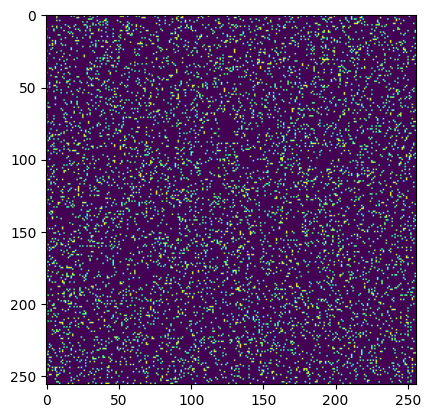

In [51]:
plt.imshow(mask[:256, :256])

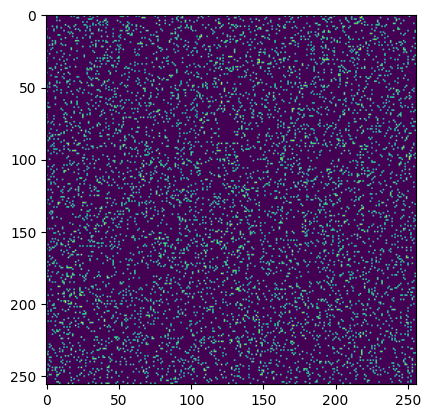

In [52]:
plt.imshow(W[:256, :256])

In [58]:
from scipy.signal import convolve
n_examples = 5000
examples = np.zeros((10, n_examples, 784))
for i in range(10):
    examples[i] = k_cap(
        convolve(
            train_imgs[train_labels == i][:n_examples].reshape(-1, 28, 28), 
            np.ones((1, 3, 3)), 
            mode='same'
        ).reshape(-1, 28 * 28), cap_size
    )

In [67]:
example_0 = examples[0]
example_0.shape

(5000, 784)

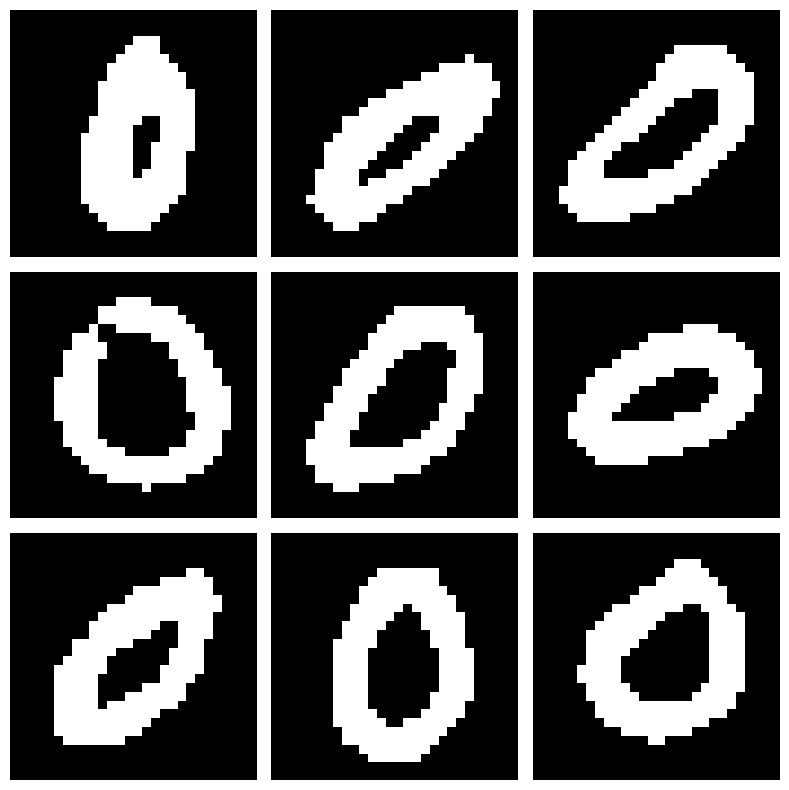

In [68]:
# Assuming 'examples' is defined and contains your dataset
# For instance, examples[0][0] to examples[0][8] are the data points you want to plot

fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axes.flatten()):
    # Reshape each example into a 28x28 image and display it
    ax.imshow(example_0[i].reshape(28, 28), cmap='gray')
    ax.axis('off')  # Hide the axes ticks

plt.tight_layout()
plt.show()


In [12]:
W = np.ones_like(W) * mask
A = np.ones_like(A) * mask_a
W /= W.sum(axis=0, keepdims=True)
A /= A.sum(axis=0, keepdims=True)
bias = np.zeros(n_neurons)
b = -1
activations = np.zeros((10, n_rounds, n_neurons))
for i in range(10):
    act_h = np.zeros(n_neurons)
    for j in range(n_rounds):
        input = examples[i, j]
        act_h_new = k_cap(act_h @ W + input @ A + bias, cap_size)
        
        activations[i, j] = act_h_new.copy()  # use later

        # apply learning to synapses
        A[(input > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
        W[(act_h > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta

        act_h = act_h_new

    # neurons that did work become less sensitive
    bias[act_h > 0] += b

    # normalize all synapses
    A /= A.sum(axis=0, keepdims=True)
    W /= W.sum(axis=0, keepdims=True)

In [13]:
outputs = np.zeros((10, n_rounds+1, n_examples, n_neurons))
for i in tqdm(range(10)):
    # hold input fixed at this mnist digit
    # & do 5 cycles
    for j in range(n_rounds):
        outputs[i, j+1] = k_cap(outputs[i, j] @ W + examples[i] @ A, cap_size)

# now, for each input, we can observe the network state at each timestep

100%|██████████| 10/10 [00:54<00:00,  5.50s/it]


In [14]:
idx = np.full(n_neurons, -1, dtype=int)

# 🔸 choose: either use activations from during-learning
#    or intermediate outputs from after-learning 
# act = outputs[:, -1].sum(axis=1)
act = activations[:, -1].copy()

for i in range(10):  # i, j in enumerate(range(10)): wtf peeples
    j = i  # ???
    idx[i*cap_size:(i+1)*cap_size] = act[j].argsort()[-cap_size:][::-1]
    act[:, idx[i*cap_size:(i+1)*cap_size]] = -1
r = np.arange(n_neurons)
r[idx[idx > -1]] = -1
idx[(i+1)*cap_size:] = np.unique(r)[1:]

Text(0.04, 0.5, 'Samples')

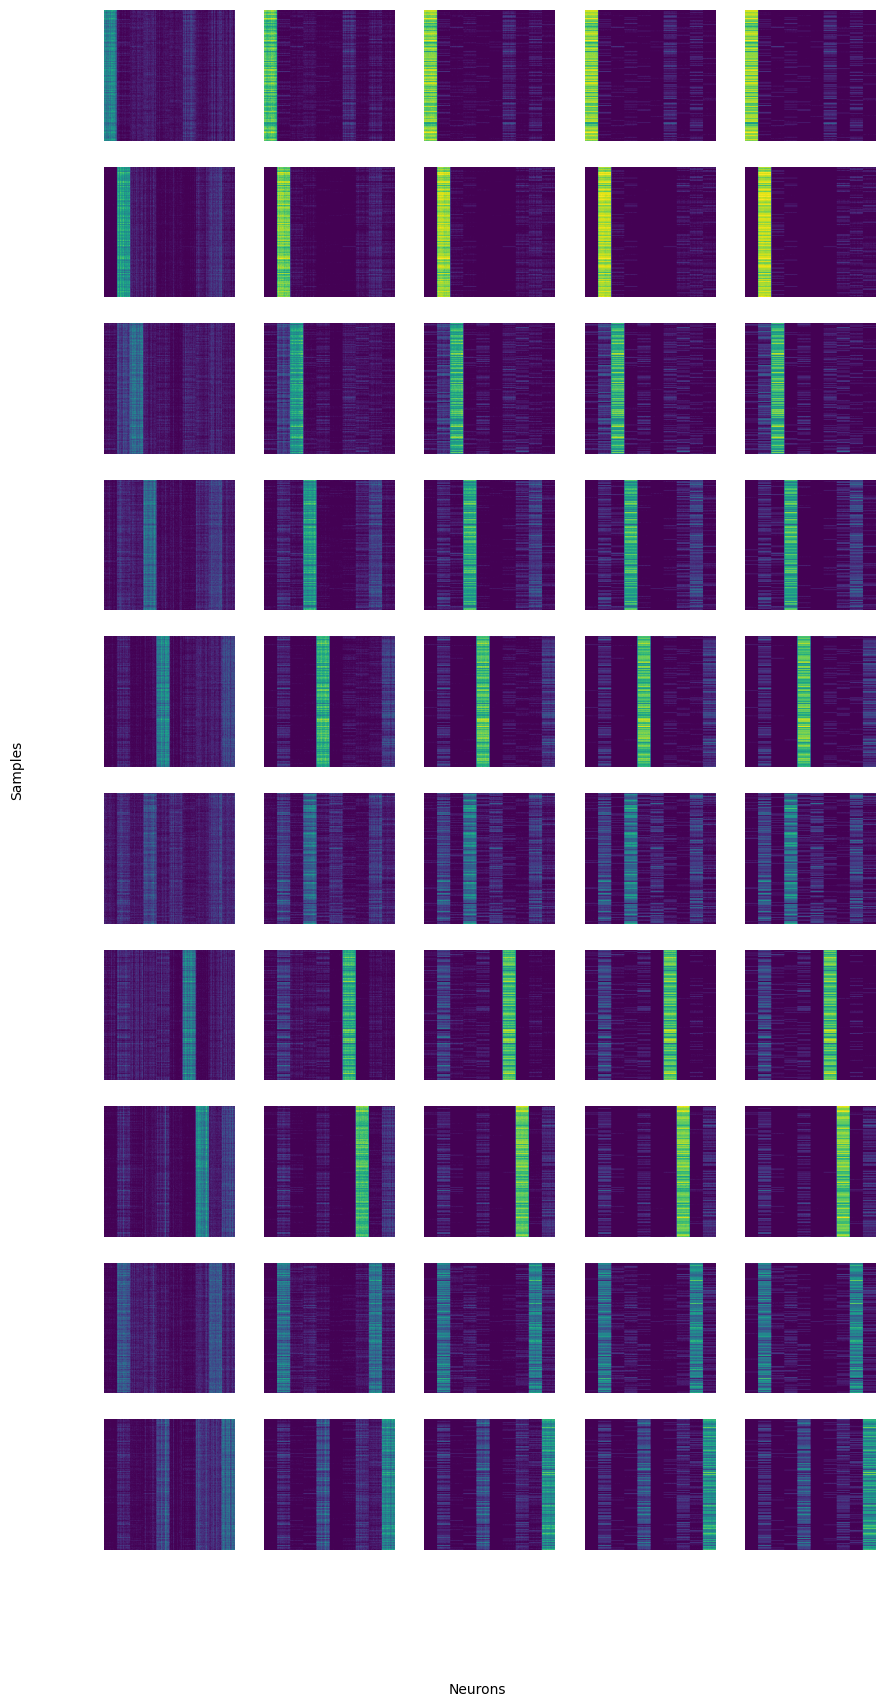

In [15]:
fig, axes = plt.subplots(10, n_rounds, figsize=(10, 2 * 10), sharex=True, sharey=True)
for ax, output in zip(axes, outputs):
    for i in range(n_rounds):
        ax[i].imshow((output[i+1] > 0)[:n_neurons, idx])
        ax[i].set_axis_off()
fig.text(0.5, 0.04, 'Neurons', ha='center', va='center')
fig.text(0.04, 0.5, 'Samples', ha='center', va='center', rotation='vertical')

In [16]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1, keepdims=True)

In [17]:
v = 0.1 * rng.standard_normal((10, n_neurons))
targets = np.zeros((100, 10))
for i in range(10):
    targets[i*10:(i+1)*10, i] = 1
update = np.zeros_like(v)

In [18]:
for _ in tqdm(range(100)):
    permutation = rng.permutation(n_examples - 1000)
    for j in range((n_examples - 1000) // 10):
        batch = outputs[:, 1, permutation[j*10:(j+1)*10]].reshape(10 * 10, n_neurons)
        scores = softmax((batch[:, :, np.newaxis] * v.T[np.newaxis, :, :]).sum(axis=1))
        update = 0.5 * update + 1e-3 * (batch[:, np.newaxis, :] * (scores - targets)[:, :, np.newaxis]).sum(axis=0)
        v -= update
#             v = v.clip(min=0.0, max=1.0)
#             v[v < 1e-5] = 0.

100%|██████████| 100/100 [03:22<00:00,  2.02s/it]


In [63]:
((outputs[:, 1, :-1000] @ v.T).argmax(axis=-1) == np.arange(10)[:, np.newaxis]).sum() / 40000

0.99775

In [65]:
((outputs[:, 1, -1000:] @ v.T).argmax(axis=-1) == np.arange(10)[:, np.newaxis]).sum() / 10000

0.9348

Text(0, 0.5, 'Firing Probability')

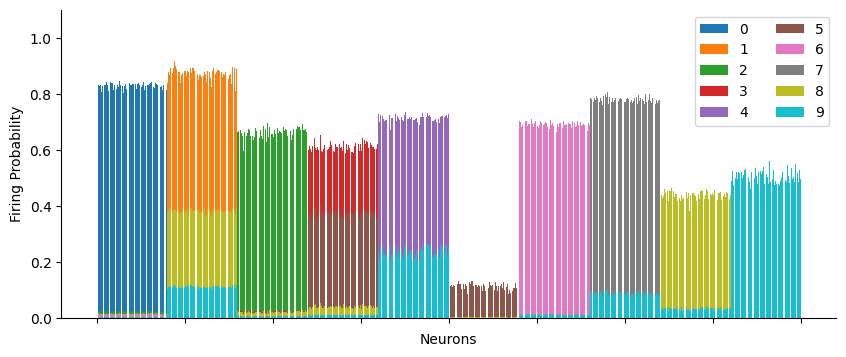

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(10):
    ax.bar(np.arange(n_neurons), outputs[i, -1].mean(axis=0)[idx], label=i)
ax.legend(loc='upper right', ncol=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, 1.1])
ax.set_xticklabels([])
ax.set_xlabel('Neurons')
ax.set_ylabel('Firing Probability')

In [22]:
c = np.zeros((10, n_neurons))
for i in range(10):
    c[
        i,
        outputs[i, 1].sum(axis=0).argsort()[-cap_size:]
    ] = 1
#     c[i, idx[i*cap_size:(i+1)*cap_size]] = 1
predictions = (outputs[:, 1] @ c.T).argmax(axis=-1)
acc = (predictions == np.arange(10)[:, np.newaxis]).sum(axis=-1) / n_examples

In [23]:
acc

array([0.8894, 0.8968, 0.7552, 0.7474, 0.7082, 0.4812, 0.7242, 0.7918,
       0.574 , 0.6642])

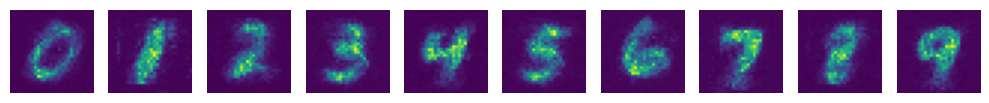

In [24]:
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    axes[i].imshow((A * c[i][np.newaxis, :]).sum(axis=1).reshape(28, 28))
    axes[i].set_axis_off()
fig.tight_layout()